In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hepmc import *

In [527]:
class FunctionBasis(object):

    def __init__(self, in_dim, out_dim=1):
        self.in_dim = in_dim
        self.out_dim = out_dim

    def output_matrix(self, xs, params):
        raise NotImplementedError

    def random_node_params(self, node_count):
        raise NotImplementedError
        
    def gradient(self, out_weights, node_params, xs):
        raise NotImplementedError
        
    def output(self, out_weights, node_params, xs):
        """
        :param xs: Numpy array, positions to evaluate function at.
        :return: The approximated function value at the given positions.
        """
        xs = util.interpret_array(xs, self.in_dim)

        out = np.dot(self.output_matrix(xs, node_params), out_weights)
        return out
    
    def output_vectorial(self, out_weights, node_params, *xs):
        if np.isscalar(xs[0]):
            # xs are numbers
            xs = np.stack(xs, axis=0)
            return self.output(out_weights, node_params, xs)
        else:
            shape = np.asanyarray(xs[0]).shape
            xs = np.stack([np.asanyarray(x).flatten() for x in xs], axis=1)
            res = self.output(out_weights, node_params, xs)
            return res.reshape(shape)
    
    def gradient_vectorial(self, out_weights, node_params, *xs):
        if np.isscalar(xs[0]):
            # xs are numbers
            xs = np.stack(xs, axis=0)
            return self.output(out_weights, node_params, xs)
        else:
            shape = np.asanyarray(xs[0]).shape
            xs = np.stack([np.asanyarray(x).flatten() for x in xs], axis=1)
            res = self.gradient(out_weights, node_params, xs)
            return res.reshape((*shape, self.in_dim))


class AdditiveBasis(FunctionBasis):

    def __init__(self, in_dim, out_dim=1, weight_range=(-1, 1), bias_range=(0, -1)):
        """ Linear combination of input followed by non-linear function.

        This class uses the model for additive activation functions from
        "Hamiltonian Monte Carlo acceleration using surrogate
        functions with random bases" (ArXiv ID: 1506.05555):

        If the input is xj and the input weights are wi with biases bi
        (the index i corresponds to the i-th node), the output is
        z(xj) = sum_i gi(wi * xj + bi),
        where the wi and xj are all ndim-dimensional and bi are scalars,
        gi are the activation functions.


        Note that the behaviour is different from Radial Base functions, since
        the position of the "centers" do not only depend on the biases.
        The weights do scale the base function, however it is only applied
        linearly in one dimension.

        Assuming all gi = g are the same and g has a center at 0 (as they would
        be for radial base functions). Then the center for node i would be at
        bi / wi. This behavior can be problematic if g is radial/centered,
        as the biases can not be chosen just based on the x-space region.
        Additionally the bounds for the input biases could not be chosen just
        based on the x-space, thus additive base functions are not a substitute
        for radial base functions.

        :param dim: Dimensionality of variable space (value space is 1D)
        :param weight_range: Range the input weight can have.
        :param bias_range: Range the input bias can have.
        """
        super().__init__(in_dim, out_dim)

        self.weight_range = weight_range
        self.bias_range = bias_range

    def basis_function(self, inputs, fn_params):
        raise NotImplementedError

    def basis_function_gradient(self, inputs, fn_params):
        raise NotImplementedError

    def random_fn_params(self, node_count):
        raise NotImplementedError

    def output_matrix(self, xs, params, fn=None):
        biases, in_weights, fn_params = params
        if fn is None:
            fn = self.basis_function

        # inputs: node_count * in_dim
        inputs = biases[np.newaxis, :] + np.dot(xs, in_weights.transpose())

        outputs = fn(inputs, fn_params)
        return outputs

    def random_node_params(self, node_count, out_bias=False):
        biases = np.random.uniform(*self.bias_range, node_count)

        input_weights = np.random.uniform(*self.weight_range, (node_count, self.in_dim))
        if out_bias: 
            # basis function bust be != 0 at x = 0
            input_weights[0] = 0
            
        return biases, input_weights, self.random_fn_params(node_count)

    def gradient(self, out_weights, params, xs):
        xs = util.interpret_array(xs, self.in_dim)

        out_matrix = self.output_matrix(xs, params, self.basis_function_gradient)
        # n: sample, m: out_dimension, k: in_dimension
        out = np.einsum('ni,im,ik->nmk', out_matrix, out_weights, params[1])
        return out


class RadialBasis(FunctionBasis):

    def __init__(self, in_dim, out_dim=1, width_range=(.01, 1), center_range=(0, 1)):
        """ Linear combination of input followed by non-linear function.

        For a given number of nodes N, use N ndim-dimensional centers ci
        (s.t. -ci is the bias) and N widths wi (1-dim) to approximate
        the output to xi input points:
        z(xi) = sum_i gi( | (xi + bi) / (2wi) |)
        where gi are activation functions taking 1D inputs.

        :param in_dim: Dimensionality of input space.
        :param out_dim: Dimensionality of output space.
        :param width_range: Range the widths can be in. Tuple of either scalars
            or in_dim-dimensional numpy arrays (if multi_widths is True).
        :param center_range: Range the centers can be in. Choose such that
            the centers span the x-space. Tuple of either scalars or
            in_dim-dimensional numpy arrays.
        """
        super().__init__(in_dim, out_dim)

        self.weight_range = width_range
        self.bias_range = center_range

    def basis_function(self, inputs, fn_params):
        raise NotImplementedError

    def basis_function_gradient(self, inputs, fn_params):
        raise NotImplementedError

    def random_fn_params(self, node_count):
        raise NotImplementedError

    def output_matrix(self, xs, params, fn=None):
        xs = util.interpret_array(xs, self.in_dim)
        centers, widths, fn_params = params
        if fn is None:
            fn = self.basis_function

        # inputs: xs.size * node_count * ndim
        inputs = xs[:, np.newaxis, :] - centers[np.newaxis, :, :]
        inputs = (np.linalg.norm(inputs, axis=2) / widths)**2 / 2

        outputs = fn(inputs, fn_params)
        return outputs

    def random_node_params(self, node_count, out_bias=False):
        centers = np.random.uniform(*self.bias_range, (node_count, self.in_dim))

        widths = np.random.uniform(*self.weight_range, node_count)
        if out_bias:
            widths[0] = np.inf
            centers[0] = 0

        return centers, widths, self.random_fn_params(node_count)

    def gradient(self, out_weights, params, xs):
        xs = util.interpret_array(xs, self.in_dim)
        xs = np.array(xs, copy=False, subok=True, ndmin=2)
        centers, widths, fn_params = params

        out_mat = self.output_matrix(xs, params, self.basis_function_gradient)
        # j: data index, i: node index, k: in-dimension index, m: out-dimension
        out = np.einsum('ji,im,jik->jmk', out_mat, out_weights / widths ** 2,
                        (xs[:, np.newaxis, :] - centers[np.newaxis, :, :]))
        return out


# CONCRETE ADDITIVE BASES
class TrigBasis(AdditiveBasis):

    def __init__(self, in_dim, out_dim=1, weight_range=(0, 1), bias_range=(-1, 0)):
        """ Additive function basis using a single Gaussian as non-linearity.

        :param in_dim: Dimensionality of input space.
        :param out_dim: Dimensionality of output space.
        :param weight_range: Range the weight can have.
        :param bias_range: Range the input bias can have.
        """
        super().__init__(in_dim, out_dim, weight_range, bias_range)

    def basis_function(self, inputs, fn_params):
        return np.cos(inputs)

    def basis_function_gradient(self, inputs, fn_params):
        return -np.sin(inputs)

    def random_fn_params(self, node_count):
        return None


# CONCRETE RADIAL BASES
class GaussianBasis(RadialBasis):

    def __init__(self, in_dim, out_dim=1, width_range=(.01, 1), center_range=(0, 1)):
        """ Radial function basis using a single Gaussian as non-linearity.

        :param in_dim: Dimensionality of input space.
        :param out_dim: Dimensionality of output space.
        :param width_range: Range the widths can be in. Tuple of either scalars
            or ndim-dimensional numpy arrays (if multi_widths is True).
        :param center_range: Range the centers can be in. Choose such that
            the centers span the x-space. Tuple of either scalars or
            ndim-dimensional numpy arrays.
        :param multi_widths: True if the widths are ndim-dimensional, i.e.
            if the radial functions are stretched independently in each ndim.
        """
        super().__init__(in_dim, out_dim, width_range, center_range)

    def basis_function(self, inputs, fn_params):
        return np.exp(-inputs)

    def basis_function_gradient(self, inputs, fn_params):
        return -np.exp(-inputs)

    def random_fn_params(self, node_count):
        return None


In [570]:
class OSELMachine(object):
    def __init__(self, node_count, fn_basis, node_params=None):
        self.node_count = node_count
        self.fn_basis = fn_basis
        
        if node_params is None:
            node_params = fn_basis.random_node_params(node_count)
        
        self.node_params = node_params
        self.out_weights = None
        self.pinv = None
        
    def output(self, xs):
        """
        :param xs: Numpy array, positions to evaluate function at.
        :return: The approximated function value at the given positions.
        """
        if self.out_weights is None:
            raise RuntimeError("Cannot evaluate ELM before learning phase.")
        return self.fn_basis.output(self.out_weights, self.node_params, xs)    

    def output_vectorial(self, *xs):
        if self.out_weights is None:
            raise RuntimeError("Cannot evaluate ELM before learning phase.")
        return self.fn_basis.output_vectorial(self.out_weights, self.node_params, *xs)    
    
    def gradient(self, xs):
        if self.out_weights is None:
            raise RuntimeError("Cannot evaluate ELM before learning phase.")
        return self.fn_basis.gradient(self.out_weights, self.node_params, xs)    

    def gradient_vectorial(self, *xs):
        if self.out_weights is None:
            raise RuntimeError("Cannot evaluate ELM before learning phase.")
        return self.fn_basis.gradient_vectorial(self.out_weights, self.node_params, *xs)    
    
    def learn(self, xs, values):
        xs = util.interpret_array(xs, self.fn_basis.in_dim)
        values = util.interpret_array(values, self.fn_basis.out_dim)

        if self.out_weights is None:
            
            if xs.shape[0] < self.node_count:
                raise RuntimeWarning("To ensure the output matrix has full rank, "
                                     "the initial dataset should have at least "
                                     "as many samples as there are nodes.")
            out_matrix = self.fn_basis.output_matrix(xs, self.node_params)
            
#             # OLD VERSION
            pinv = np.linalg.pinv(out_matrix)
            weights = np.dot(pinv, values)
            self.out_weights = weights
            self.pinv = np.linalg.inv(out_matrix.transpose().dot(out_matrix))
            
#             self.pinv = np.dot(pinv, np.linalg.pinv(out_matrix.transpose()))
            return self.out_weights, self.pinv
        
            # NEW VERSION
            # initial learning sequence, standard ELM
            self.pinv = np.linalg.inv(out_matrix.transpose().dot(out_matrix))

            self.out_weights = np.dot(self.pinv.dot(out_matrix.transpose()), values)
            return self.out_weights, self.pinv
        
        out_matrix = self.fn_basis.output_matrix(xs, self.node_params)
        differences = values - np.dot(out_matrix, self.out_weights)
        if xs.shape[0] == 1:
            # single point update
            self.pinv -= np.einsum('ij,kj,kl,lm', self.pinv, out_matrix, out_matrix, self.pinv) / (
                         1 + np.einsum('ij,jk,lk', out_matrix, self.pinv, out_matrix))
            self.out_weights += np.einsum('ij,kj,kl', self.pinv, out_matrix, differences)
            return self.out_weights, self.pinv
    
#         # iterative batch update
#         svd = np.linalg.pinv(1 + np.einsum('ij,jk,lk', out_matrix, self.pinv, out_matrix))
#         self.pinv -= np.einsum('ij,kj,kl,lm,mn', self.pinv, out_matrix, svd, out_matrix, self.pinv)
#         self.out_weights += np.einsum('ij,kj,kl', self.pinv, out_matrix, differences)
#         return self.out_weights, self.pinv
        H = self.fn_basis.output_matrix(xs, self.node_params)
        HT = H.transpose()
        HTH = np.dot(HT, H)
        batch_size = xs.shape[0]
        I = np.eye(batch_size)
        Hp = np.dot(H, self.pinv)
        HpHT = np.dot(Hp, HT)
        temp = np.linalg.inv(I + HpHT)
        pHT = np.dot(self.pinv, HT)
        self.pinv = p = self.pinv - np.dot(np.dot(pHT, temp), Hp)
        pHT = np.dot(p, HT)
        Hbeta = np.dot(H, self.out_weights)
        self.out_weights = out_weights = self.out_weights + np.dot(pHT, values - Hbeta)
        return out_weights

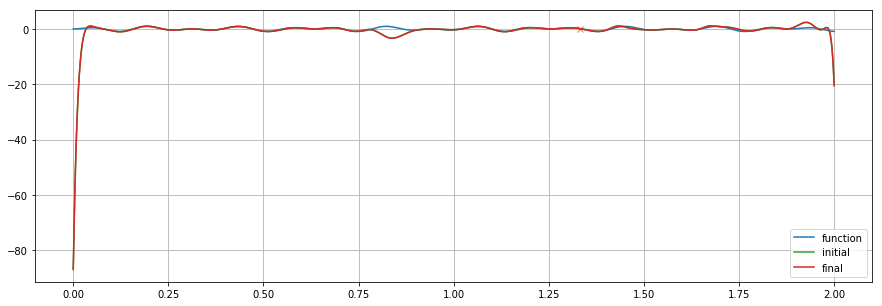

In [574]:
# basis = TrigBasis(1, 1, (0, 100), (-1, 0))
basis = GaussianBasis(1, center_range=(0, 2), width_range=(0.01, 1))

N = 81
node_count = 80
split = 80

fn = lambda xs: np.sin(40 * xs)*np.sin(10*xs)
xs = np.random.rand(N).astype(np.double).reshape(N, 1)*2
values = fn(xs)

elm = OSELMachine(node_count, basis)
elm.learn(xs[:split], values[:split])

plt.figure(figsize=(15, 5))

x = np.linspace(0, 1, 1000) * 2
plt.plot(x, fn(x), label="function")
plt.plot(xs[split:], values[split:], 'x')
plt.plot(x, elm.output(x), label="initial")
# plt.plot(x, elm.gradient_vectorial(x)/100, label="gradient")
# plt.plot(-params[0], [-1.5]*node_count, '+')

# elm.learn(xs[split:], values[split:])
for i in range(node_count, N):
    elm.learn(xs[i], values[i])

plt.plot(x, elm.output(x), label="final")

plt.legend()
plt.grid()
plt.show()

In [515]:
out_matrix = elm.fn_basis.output_matrix(xs[split:], elm.node_params)
differences = values[split:] - np.dot(out_matrix, elm.out_weights)
inn = 1 + np.einsum('ij,jk,lk', out_matrix, elm.pinv, out_matrix)
u, s, vh = np.linalg.svd(inn, full_matrices=True)
svd = vh.transpose().dot(np.diag(1/s).dot(u.transpose()))
# svd = np.linalg.pinv(inn)
newpinv = elm.pinv - np.einsum('ij,kj,kl,lm,mn', elm.pinv, out_matrix, svd, out_matrix, elm.pinv)
dow = np.einsum('ij,kj,kl', elm.pinv, out_matrix, differences)

In [521]:
elm.out_weights[0]

array([4291.4733847])

In [390]:
svd.shape

(920, 920)

In [406]:
newpinv.shape

(80, 80)

In [266]:
np.dot(inn, np.linalg.inv(inn)).shape

(960, 960)

In [276]:
inn

array([[ 6.92711960e+02,  2.24265962e+02, -2.56453827e+02, ...,
         5.40166694e+01, -1.66767859e+03, -3.55531521e+01],
       [ 2.24265962e+02,  6.66767635e+02, -5.36783090e+01, ...,
         1.49163324e+02, -3.29260631e+03, -3.07884066e+00],
       [-2.56453827e+02, -5.36783086e+01,  7.46217186e+02, ...,
        -9.88733076e+00,  6.75099703e+02,  6.78416290e+00],
       ...,
       [ 5.40166695e+01,  1.49163324e+02, -9.88733086e+00, ...,
         3.47794871e+01, -7.37631016e+02, -1.35225393e-01],
       [-1.66767859e+03, -3.29260631e+03,  6.75099705e+02, ...,
        -7.37631016e+02,  1.73306348e+04,  5.49675494e+01],
       [-3.55531521e+01, -3.07884064e+00,  6.78416290e+00, ...,
        -1.35225388e-01,  5.49675493e+01,  4.10470767e+00]])

In [428]:
out_matrix = elm.fn_basis.output_matrix(xs[:80], elm.node_params)
inns = out_matrix.transpose().dot(out_matrix)
pinv = np.linalg.pinv(inns)

In [429]:
np.allclose(np.dot(inns, pinv), np.eye(80), atol=1e-1)

False

In [22]:
class Foo(object):
    __slots__ = ['foo', 'bar']
    def __init__(self):
        self.foo = 3
    def __repr__(self):
        return str(self.foo)
    
class Bar(Foo):
    def __init__(self, x):
        self.x = x
        super().__init__()

In [28]:
f = Foo()
b = Bar(3)

In [32]:
b.__dict__

{'x': 3}

In [15]:
e_cm = 100.
mapping = phase_space.RamboOnDiet(e_cm, 2)
target = phase_space.MappedDensity(densities.ee_qq(e_cm), mapping)

In [16]:
int_sample = PlainMC(2)(target, 50000)
int_sample.integral, int_sample.integral_err

(206.91544604786137, 0.37769277854129757)

In [17]:
target.norm = int_sample.integral

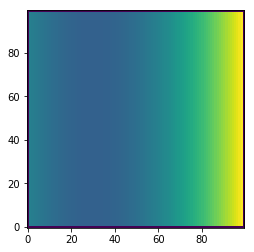

In [18]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100) 
mgrid = np.meshgrid(x, y)
prob = target(*mgrid)
plt.imshow(prob, origin='lower')

In [19]:
sampler = DefaultMetropolis(2, target)
sample =sampler.sample(1000, [.5, .5])

data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
1000,[0.58881065 0.49209412],[0.08595379 0.08886738],"1.524, p=0.02435, N=36",None,0.800000


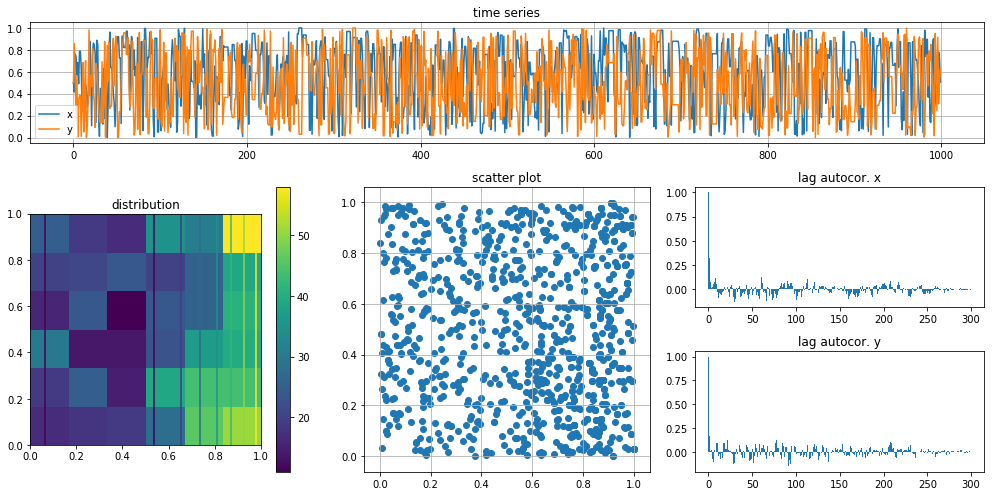

In [9]:
sample

/home/mathis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


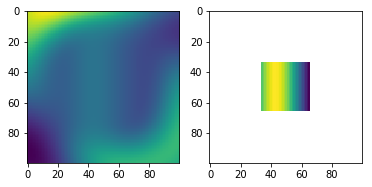

In [41]:
nodes = 50
nlearn = 1000
x = np.linspace(-1, 2, 100)
y = np.linspace(-1, 2, 100)
mgrid = np.meshgrid(x, y)

xvals = np.random.random((nlearn, 2))
fvals = target.pdf(xvals)

# surrogate
basis = surrogate.extreme_learning.GaussianBasis(2)
log_vals = -np.ma.log(fvals)
xvals = xvals[~log_vals.mask]
log_vals = log_vals[~log_vals.mask]
# train
params = basis.extreme_learning_train(xvals, log_vals, nodes)

# surrogate gradient
def surrogate_gradient(xs):
    return basis.eval_gradient(*params, xs)
target.pot_gradient = surrogate_gradient
util.count_calls(target, 'pot_gradient')

plt.subplot(121)
plt.imshow(basis.eval_split(*params, *mgrid))
plt.subplot(122)
plt.imshow(-np.log(target(*mgrid)))
plt.show()

In [80]:
sampler = hamiltonian.StaticSphericalHMC(target, .03, .03, 30, 30)
# (target, 2, .5, 1., 30, .001)

In [82]:
sample = sampler.sample(1000, initial, log_every=200)

Generated 200 samples.
Generated 400 samples.
Generated 600 samples.
Generated 800 samples.
Generated 1000 samples.


data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
1000,[0.6354019 0.52481684],[0.08358836 0.07933143],"3.175, p=5.506e-11, N=41",None,0.999000


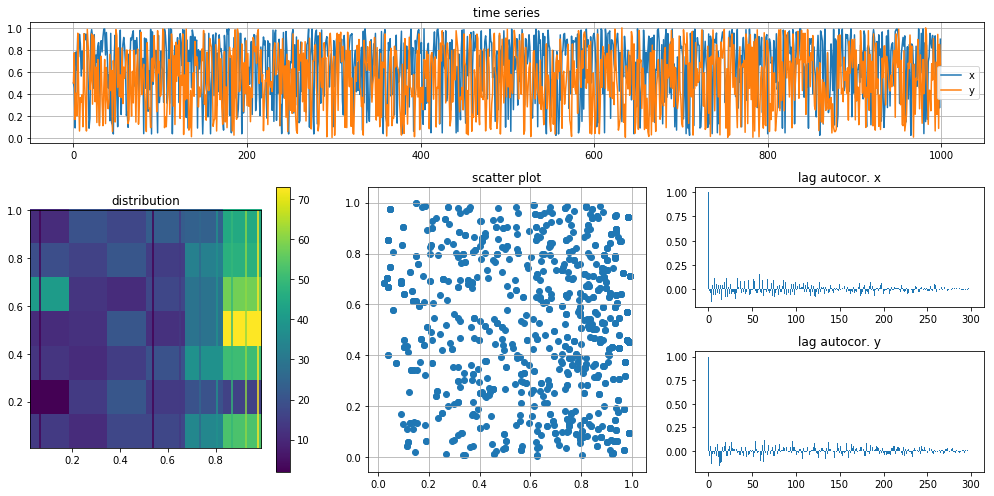

In [83]:
sample

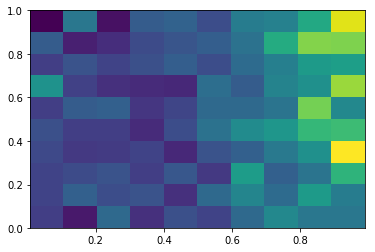

In [79]:
plt.hist2d(*sample.data.transpose(), 10)
plt.show()